In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
import torch
from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity
import mutagenicity_utils
import numpy as np
import ops
import torch.nn.functional as F
from main_mutagenicity import evaluate
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

DEVICE: cuda


In [4]:
import json

saved_name = 'marqv0xz' #'y3fy898v'
epoch = 99
PATH = f'./saved/{saved_name}/ckpt/epoch{epoch}.ckpt'
ckpt = torch.load(PATH, weights_only=True, map_location=device)

with open(f'./saved/{saved_name}/params.json') as json_file:
    train_params = json.load(json_file)

In [5]:
# Set random seeds
torch.manual_seed(train_params['seed'])
# random.seed(train_params['seed'])
np.random.seed(train_params['seed'])

In [6]:
classifier = ClassifierMutagenicity(queryset_size=403).to(device)
querier = QuerierMutagenicity(queryset_size=403, tau=1.0).to(device)

Since the model was trained with nn.DataParallel, and we called model.state_dict() in torch.save() instead of model.module.state_dict(), we still have that "module." wrapper in from of the keys of the state_dict. Next time, save the state_dict correctly, but for now, we must remove the wrapper from the key names.

In [7]:
from collections import OrderedDict

# Classifier
state_dict = ckpt['classifier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

classifier.load_state_dict(new_state_dict)

# Querier
state_dict = ckpt['querier']
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    # Remove the 'module.' prefix if it exists
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

querier.load_state_dict(new_state_dict)

<All keys matched successfully>

Load Mutagenicity dataset and queryset.

In [8]:
from dataset import load_mutagenicity_dataset, load_mutagenicity_queryset

dataset_root = './data/Mutagenicity'
queryset_root = './experiments/rdkit_querysets/queryset_1.csv'

dataset = load_mutagenicity_dataset(dataset_root)
trainset, testset = load_mutagenicity_queryset(dataset_root, queryset_root, train_ratio=0.8, seed=train_params['seed'])

Loading and processing Mutagenicity dataset for training...


100%|██████████| 4337/4337 [00:03<00:00, 1160.84it/s]


Splitting into train and test sets...
Loading complete.


# Single Sample Posterior Probability Heatmap

In [9]:
# Good examples: 2000 (from original raw dataset)
testset_idx = 10
qry_ans = testset[testset_idx]

dataset_idx = qry_ans[2] 
data = dataset[dataset_idx]

test_features = qry_ans[0].unsqueeze(0)  # (1, N_QUERIES)
test_labels = qry_ans[1].unsqueeze(0)  # (1)
test_sample_id = qry_ans[2].unsqueeze(0)  # (1)

test_features = test_features.to(device)
test_labels = test_labels.to(device)

print(test_features.shape)
print(test_labels.shape)
print(test_sample_id)

torch.Size([1, 403])
torch.Size([1])
tensor([2783])


In [10]:
G = mutagenicity_utils.raw_to_nx(data)
mol = mutagenicity_utils.nx_to_rdkit(G)

Set evaluation parameters.

In [11]:
N_QUERIES = 403
max_queries_test = train_params['max_queries_test']
THRESHOLD = train_params['threshold']

In [12]:
params = {
    'test_features': test_features,
    'querier': querier,
    'classifier': classifier,
    'n_queries': N_QUERIES,
    'max_queries_test': max_queries_test,
}
logits, queries = evaluate(**params)

In [13]:
# prediction using all queries (last query?)
test_pred_max = logits[:, -1, :].argmax(dim=1).float()  # Why are we taking the last query logits always?
# test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()

# compute number of queries needed for prediction
qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)

# prediction using IP
test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
# test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()

print(test_pred_max)
print(test_pred_ip)

tensor([0.], device='cuda:0')
tensor([0], device='cuda:0')


In [14]:
# Get query answer pairs that querier produced, but in natural language that 
q_ans_pairs = []
for q in queries[0]:
    q_idx = torch.argmax(q).item()
    q_name = mutagenicity_utils.get_query_name_list()[q_idx]
    q_ans = qry_ans[0][q_idx].item()
    q_ans_pairs.append((q_name, q_ans))

q_ans_pairs

[('allylic_oxid=0', 1),
 ('NH0=0', -1),
 ('nitroso=1', -1),
 ('Ndealkylation2=1', -1),
 ('ArN=0', 1),
 ('bicyclic=0', -1),
 ('bicyclic=1', -1),
 ('Al_OH=0', 1),
 ('COO=1', -1),
 ('benzene=1', -1),
 ('epoxide=0', 1),
 ('Ar_OH=0', 1),
 ('COO2=0', 1),
 ('halogen=0', 1),
 ('sulfonamd=1', -1),
 ('nitroso=0', 1),
 ('methoxy=1', -1),
 ('C_O_noCOO=4', -1),
 ('NH1=1', -1),
 ('ester=1', -1)]

In [15]:
# Get the functional groups and their counts present in the sample, in natural language
all_frag_counts = mutagenicity_utils.onehot_to_interpretable_dict(qry_ans[0])
frag_count_list = []
for frag, count in all_frag_counts.items():
    if count > 0:
        frag_count_list.append((frag, count))

frag_count_list

[('Ar_N', 4),
 ('NH0', 4),
 ('benzene', 4),
 ('bicyclic', 8),
 ('imidazole', 2),
 ('para_hydroxylation', 4),
 ('pyridine', 2)]

Posterior Probability Heatmap (like Figure 3b and 3c in paper)

In [16]:
logits

tensor([[[ 0.1445, -0.1568],
         [ 0.2756, -0.2768],
         [-0.0767,  0.0662],
         [ 0.4017, -0.3956],
         [ 0.3189, -0.3266],
         [ 0.4265, -0.4168],
         [ 0.7112, -0.6604],
         [ 1.1507, -1.0723],
         [ 1.2378, -1.1482],
         [ 1.2206, -1.1135],
         [ 1.0568, -0.9577],
         [ 1.2104, -1.1141],
         [ 1.3722, -1.2521],
         [ 1.5490, -1.4237],
         [ 1.7626, -1.6365],
         [ 1.5572, -1.4393],
         [ 1.2485, -1.1477],
         [ 1.5093, -1.3950],
         [ 1.3180, -1.2083],
         [ 1.3418, -1.2321]]], device='cuda:0')

In [17]:
probs = F.softmax(logits, dim=2)
probs

tensor([[[0.5748, 0.4252],
         [0.6347, 0.3653],
         [0.4643, 0.5357],
         [0.6894, 0.3106],
         [0.6560, 0.3440],
         [0.6992, 0.3008],
         [0.7976, 0.2024],
         [0.9023, 0.0977],
         [0.9158, 0.0842],
         [0.9117, 0.0883],
         [0.8823, 0.1177],
         [0.9109, 0.0891],
         [0.9324, 0.0676],
         [0.9513, 0.0487],
         [0.9677, 0.0323],
         [0.9524, 0.0476],
         [0.9165, 0.0835],
         [0.9481, 0.0519],
         [0.9260, 0.0740],
         [0.9292, 0.0708]]], device='cuda:0')

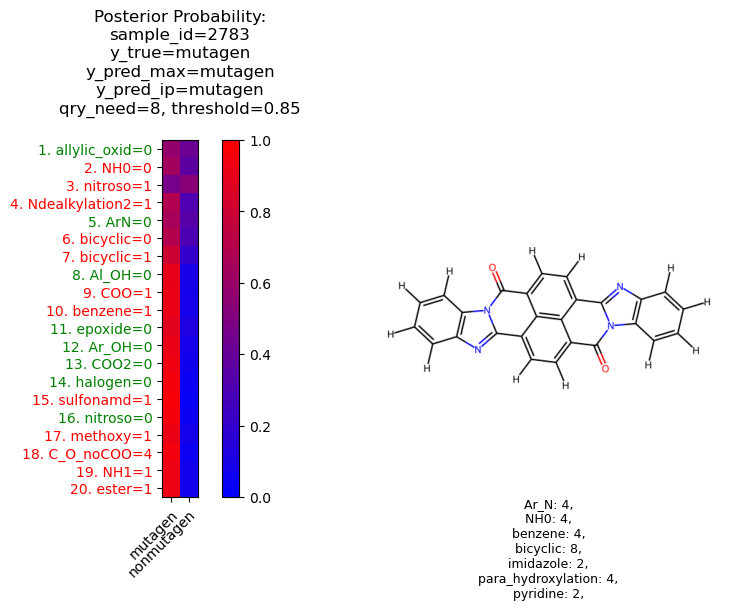

In [18]:
params = {
    'probs': probs[0],
    'queries': queries[0], 
    'answers': test_features[0], 
    'y_true': data.y.item(),
    'y_pred_max': test_pred_max.item(),
    'y_pred_ip': test_pred_ip.item(),
    'qry_need': qry_need.item(),
    'threshold': THRESHOLD,
    'sample_id': test_sample_id.item(),
    'mol': mol
}
fig, ax = mutagenicity_utils.create_posterior_prob_heatmap(**params);

Sanity Check: Evaluate on entire test set and see if test accuracy is same as that during train/test procedure (To make sure I'm using the same test set)

In [19]:
trainloader = DataLoader(trainset, batch_size=train_params['batch_size'], num_workers=4)
testloader = DataLoader(testset, batch_size=train_params['batch_size'], num_workers=4)

epoch_test_qry_need = []
epoch_test_acc_max = 0
epoch_test_acc_ip = 0
for test_features, test_labels, _ in tqdm(testloader):
    test_features = test_features.to(device)
    test_labels = test_labels.to(device)

    params = {
        'test_features': test_features,
        'querier': querier,
        'classifier': classifier,
        'n_queries': N_QUERIES,
        'max_queries_test': max_queries_test,
    }
    logits, queries = evaluate(**params)

    # accuracy using all queries
    test_pred_max = logits[:, -1, :].argmax(dim=1).float()
    test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()
    epoch_test_acc_max += test_acc_max

    # compute number of queries needed for prediction
    qry_need = ops.compute_queries_needed(logits, threshold=THRESHOLD)
    epoch_test_qry_need.append(qry_need)

    # accuracy using IP
    test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
    test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()
    epoch_test_acc_ip += test_acc_ip
epoch_test_acc_max = epoch_test_acc_max / len(testset)
epoch_test_acc_ip = epoch_test_acc_ip / len(testset)

# mean and std of queries needed
epoch_test_qry_need = torch.hstack(epoch_test_qry_need).float()
qry_need_avg = epoch_test_qry_need.mean()
qry_need_std = epoch_test_qry_need.std()

100%|██████████| 7/7 [00:00<00:00, 34.55it/s]


In [20]:
print(epoch_test_acc_max)
print(epoch_test_acc_ip)
print(qry_need_avg)
print(qry_need_std)

tensor(0.7177, device='cuda:0')
tensor(0.7120, device='cuda:0')
tensor(15.1440, device='cuda:0')
tensor(5.8660, device='cuda:0')


# Fixed Query Budget vs Test Accuracy Plot

In [56]:
trainloader = DataLoader(trainset, batch_size=train_params['batch_size'], num_workers=4)
testloader = DataLoader(testset, batch_size=train_params['batch_size'], num_workers=4)

max_query_budget = 403
test_accs = [] 
TESTSET_SIZE = len(testset)
for max_queries_test in range(1, max_query_budget+1):
    epoch_test_acc_max = 0
    for test_features, test_labels, _ in tqdm(testloader):
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)

        params = {
            'test_features': test_features,
            'querier': querier,
            'classifier': classifier,
            'n_queries': N_QUERIES,
            'max_queries_test': max_queries_test,
        }
        logits, queries = evaluate(**params)

        # accuracy using all queries
        test_pred_max = logits[:, -1, :].argmax(dim=1).float()
        test_acc_max = (test_pred_max == test_labels.squeeze()).float().sum()
        epoch_test_acc_max += test_acc_max
    epoch_test_acc_max = epoch_test_acc_max / TESTSET_SIZE
    test_accs.append(epoch_test_acc_max.item())

100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


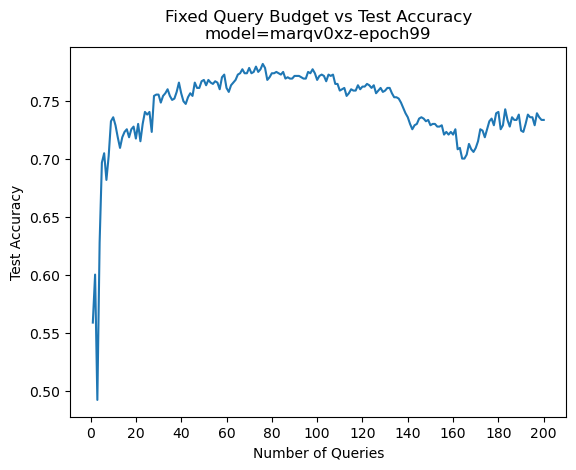

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(1, max_query_budget+1)
y = test_accs

# ax.set_xticks(np.arange(max_query_budget+1))
ax.set_xticks(range(0, max_query_budget+1, 50))
ax.plot(x, y)

ax.set_title(f'Fixed Query Budget vs Test Accuracy\nmodel={saved_name}-epoch{epoch}')
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Test Accuracy')

plt.show()

# Avg Num Queries Needed Given Threshold vs Test Accuracy 

In [44]:
trainloader = DataLoader(trainset, batch_size=train_params['batch_size'], num_workers=4)
testloader = DataLoader(testset, batch_size=train_params['batch_size'], num_workers=4)

threshold_list = np.arange(0.05, 1, 0.05)
test_accs = []
qry_need_nums = []
for threshold in threshold_list:
    epoch_test_acc_ip = 0
    epoch_test_qry_need = []
    for test_features, test_labels, _ in tqdm(testloader):
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)

        params = {
            'test_features': test_features,
            'querier': querier,
            'classifier': classifier,
            'n_queries': N_QUERIES,
            'max_queries_test': N_QUERIES,
        }
        logits, queries = evaluate(**params)

        # compute number of queries needed for prediction
        qry_need = ops.compute_queries_needed(logits, threshold=threshold)
        epoch_test_qry_need.append(qry_need)

        # accuracy using IP
        test_pred_ip = logits[torch.arange(len(qry_need)), qry_need-1].argmax(1)
        test_acc_ip = (test_pred_ip == test_labels.squeeze()).float().sum()
        epoch_test_acc_ip += test_acc_ip

    # overall test accuracy    
    epoch_test_acc_ip = epoch_test_acc_ip / TESTSET_SIZE
    test_accs.append(epoch_test_acc_ip.item())

    # mean and std of queries needed
    epoch_test_qry_need = torch.hstack(epoch_test_qry_need).float()
    qry_need_nums.append(epoch_test_qry_need)

100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


In [45]:
qry_need_avgs = [qry_need.mean().item() for qry_need in qry_need_nums]
qry_need_stds = [qry_need.std().item() for qry_need in qry_need_nums]

# print(qry_need_avgs)
# print(qry_need_stds)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


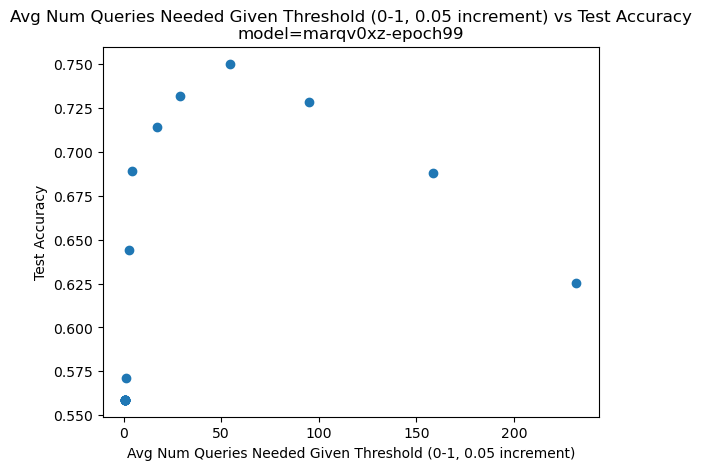

In [55]:
fig, ax = plt.subplots()

x = qry_need_avgs
y = test_accs

# ax.set_xticks()
ax.scatter(x, y)

ax.set_title(f'Avg Num Queries Needed Given Threshold (0-1, 0.05 increment) vs Test Accuracy\nmodel={saved_name}-epoch{epoch}')
ax.set_xlabel('Avg Num Queries Needed Given Threshold (0-1, 0.05 increment)')
ax.set_ylabel('Test Accuracy')

print(threshold_list)
plt.show()